In [64]:
import cv2, os
import pickle
from sklearn import svm
from skimage import io
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import PIL.Image as Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### Training Part

##### 1. Using HOG to extract features

In [65]:
'''Defaut parametres for cv2.HOGDescriptor(), we can set them by ourselves.'''

winSize = (64,128) 
blockSize = (16,16) # 105 blocks
blockStride = (8,8)
cellSize = (8,8)    # Each block contains 4 cells
Bin = 9
#hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,Bin)
hog = cv2.HOGDescriptor()


In [66]:
'''Using HOG to extract features: to obtain (photoID,HOGvectors,label) likely pairs for training'''


def add_label(id, feature, label):
    #build (photoID,HOGvectors,label) likely pairs for training
    global samples
    samples[id] = np.insert(feature, 0, label)

    
    
path = "data" # file path for data
samples = {} # To save data paires likely (photoID,HOGvectors,label) 
count = 0   # index for samples
i = 0 
label = 1  # 1 means having lesion 
for p,dirs,fnames in os.walk(path):
    if p == 'data\\':
        pass
    if i == 2 :
        label=0  # 0 means no lesion
    for fname in fnames:
        pth = os.path.join(p, fname)
        img = cv2.imread(pth)
        img = cv2.resize(img,(64,128))
        feature = hog.compute(img)   # Having totally 3780 hog features, blocks * cells * bins = 105*4*9= 3780
        
        if feature is None:
            pass
        else:
            feature = feature.ravel()
            samples[count] = np.insert(feature, 0, label)
            count+=1    
    i+=1

##### 2. Training SVM  model 

In [67]:
''' Training  SVM  model . '''

def svm_(train_x,train_y):
    #clf = svm.SVC(kernel="linear", cache_size=50)
    clf = LinearDiscriminantAnalysis()
    clf.fit(train_x, train_y)
    return clf

train = []
for v in samples.values(): 
    v = v.tolist()
    train.append(v)

train = np.array(train)  

train_x = train[:,1:]  # features without label
train_y = train[:,0]  # labels

print("training...")
clf = svm_(train_x, train_y)
f = open('training_result.pickle', 'wb') # Save the SVM model and its weights in 'training_result.pickle'.
pickle.dump(clf, f)
print("finished")
f.close()

training...
finished


### Test Part

In [68]:
def test(image):
    result = {}

    #hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,Bin)
    hog = cv2.HOGDescriptor()
    h,w = image.shape
    # 64*128滑窗检测，跳数为8, 即把图像划分为多个子图，检测子图是否属于legion部分    
    for x in range(0,h-128,4):
        for y in range(0,w-64,8):
            block = image[x:x+129,y:y+65]
            #print(block.shape)
            feature = hog.compute(block)
            if feature is None:
                continue
            else:
                feature = feature.ravel().reshape(1,3780) 
                prob_temp=model.predict_proba(feature)[0][0]
                
                if prob_temp > 0.99: 
                    result[(x,y)] = 1
    return result

 
#  Merging all all sub-areas containing the lesions into a larger areas having lesions
def drawVirtrualBox2(image_ori,image_trai, res):
    count = 0
    for k,v in res.items():
        if v==0:
            continue
        x,y = k
        maxy, maxx, minx, miny = y + 64, x + 128, x, y
        for k1 in res.keys():
            x1,y1 = k1
            if minx<=x1<=maxx and miny<=y1<=maxy or miny<=y1+64<=maxy:
                res[k1]=0
                maxy = max(maxy, y1+64)
                maxx = max(maxx, x1+128)
                miny = min(miny, y1)
                minx = min(minx, x1)
        count +=1
        cv2.rectangle(image_ori, (miny,minx), (maxy,maxx), (0,0,255), 2)
        cv2.rectangle(image_trai, (miny,minx), (maxy,maxx), (0,0, 255), 2)
        
    #cv2.imshow("result", image)  # It cannot be used in jupyter notebook
    cv2.imwrite('result_merged_Box_ori.jpg', image_ori)
    cv2.imwrite('result_merged_Box_trai.jpg', image_trai)

# Detect all sub-areas containing the lesions
def drawVirtrualBox(image_ori,image_trai,res):
    for v in res.keys():
        x,y = v
        cv2.rectangle(image_ori, (y,x), (y+64,x+128), (0,0,255) ,1)
        cv2.rectangle(image_trai, (y,x), (y+64,x+128), (0,0,255) ,1)
   
    
    cv2.imwrite('result_allBox_ori.jpg', image_ori)
    cv2.imwrite('result_allBox_trai.jpg', image_trai)
    #cv2.imshow('result',image)  # It cannot be used in jupyter notebook


# load the model svm and its weights that we had trained above. 
with open('training_result.pickle','rb') as fr:
    model = pickle.load(fr)
img = np.asarray(Image.open("original.jpg").convert('L'))
result = test(img)

drawVirtrualBox(cv2.imread("original.jpg"),cv2.imread("traitement.jpg"),result)
drawVirtrualBox2(cv2.imread("original.jpg"),cv2.imread("traitement.jpg"),result)


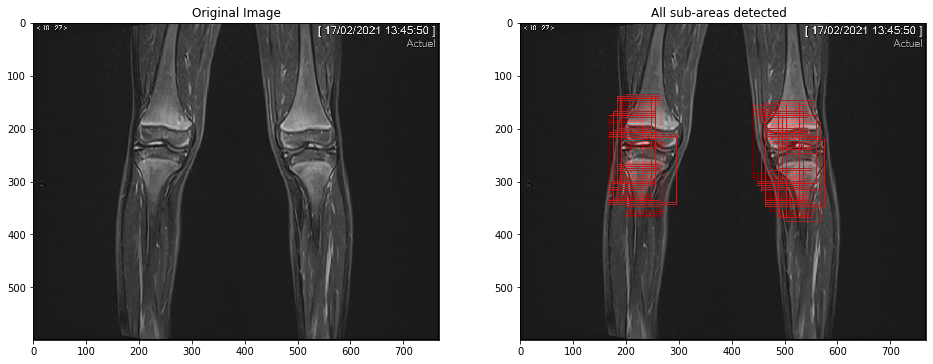

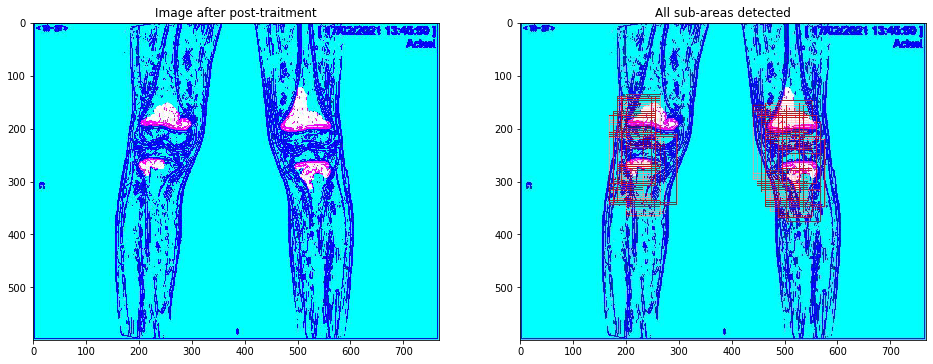

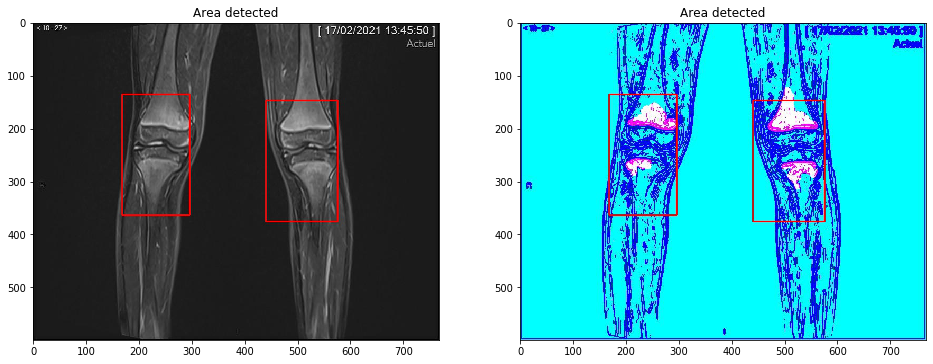

In [69]:
# show the testing results
fig, axes = plt.subplots(ncols = 4, figsize=(16, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)
img_ori = mpimg.imread('original.jpg')
ax[0].imshow(img_ori,cmap=plt.cm.gray)
ax[0].set_title('Original Image')

result_allBox_ori = mpimg.imread('result_allBox_ori.jpg')
ax[1].imshow(result_allBox_ori,cmap=plt.cm.gray)
ax[1].set_title('All sub-areas detected  ')
plt.show()



fig, axes = plt.subplots(ncols = 6, figsize=(16, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)

result_trai = mpimg.imread('traitement.jpg')
ax[0].imshow(result_trai,cmap=plt.cm.gray)
ax[0].set_title('Image after post-traitment')

result_allBox_trai = mpimg.imread('result_allBox_trai.jpg')
ax[1].imshow(result_allBox_trai,cmap=plt.cm.gray)
ax[1].set_title('All sub-areas detected')
plt.show()

fig, axes = plt.subplots(ncols = 6, figsize=(16, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[1] = plt.subplot(1, 2, 2)

result_merged_Box_ori = mpimg.imread('result_merged_Box_ori.jpg')
ax[0].imshow(result_merged_Box_ori,cmap=plt.cm.gray)
ax[0].set_title('Area detected')

result_merged_Box_trai = mpimg.imread('result_merged_Box_trai.jpg')
ax[1].imshow(result_merged_Box_trai,cmap=plt.cm.gray)
ax[1].set_title('Area detected')
plt.show()
